In [2]:
import bagpipes as pipes
import numpy as np

Modifico il file sui filtri in modo tale da avere 15 files per i 15 filtri, con due colonne riportanti lunghezze d'onda in Angstrom e trasmissione.

In [3]:
with open('COSMOS_photometry/FILTER.RES.UVISTA4.1_trimmed.R300', 'r') as f:
  lines = f.readlines()            #file con curve di trasmissione di tutti i filtri
f.close()

with open('COSMOS_photometry/FILTER.RES.UVISTA4.1_trimmed.R300.info', 'r') as f:
  markers = f.readlines()         #file con info sui filtri, le cui stringhe separano i dati nel precedente, lo uso per separare le curve dei singoli filtri 
f.close()

off = []
for mark in markers:       
 for i,line in enumerate(lines):
   if (line in mark):
    off.append(int(i))
off.append(len(lines))

filter_list = []

for i in range(len(off)-1):
   filename = 'filt_%d.txt' % (i+1)
   with open(filename, 'w') as f:
    for line in lines[off[i]+1:off[i+1]]:
      f.write(line)
    filter_list.append(filename)
   f.close()

#print(lines[off[0]+1:off[1]])


In [4]:
import pandas as pd
for filename in filter_list:
  df = pd.read_csv(filename, sep="     ", names=['Number', 'Lambda', 'Transmittance'])
  #print(df)
  df = df.drop(columns = 'Number')
  print(df)
  df.to_csv(filename, sep = ' ', header = False, index = False)

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


      Lambda  Transmittance
0     9540.0       0.025401
1     9550.0       0.028100
2     9560.0       0.033062
3     9570.0       0.037622
4     9580.0       0.043422
5     9590.0       0.050846
6     9600.0       0.059126
7     9610.0       0.068251
8     9620.0       0.079256
9     9630.0       0.092076
10    9640.0       0.107180
11    9650.0       0.124970
12    9660.0       0.146850
13    9670.0       0.173840
14    9680.0       0.204320
15    9690.0       0.238380
16    9700.0       0.276510
17    9710.0       0.316820
18    9720.0       0.356970
19    9730.0       0.400750
20    9740.0       0.445430
21    9750.0       0.494070
22    9760.0       0.541740
23    9770.0       0.588950
24    9780.0       0.631360
25    9790.0       0.673360
26    9800.0       0.707170
27    9810.0       0.735220
28    9820.0       0.759740
29    9830.0       0.778540
..       ...            ...
105  10590.0       0.785730
106  10600.0       0.748390
107  10610.0       0.708110
108  10620.0       0

[158 rows x 2 columns]


Costruisco un modello, facendo predizioni delle magnitudini nelle bande di interesse

C:\Users\Admin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


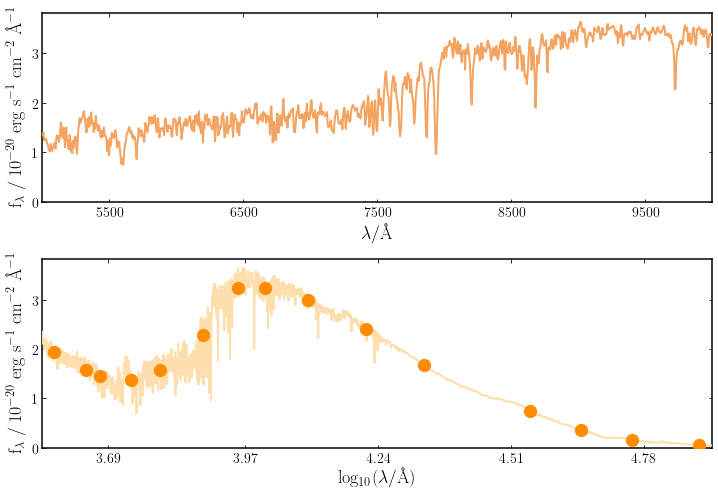

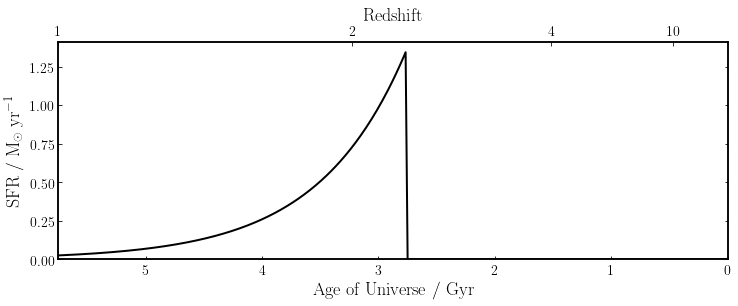

In [7]:
exp = {}                          # Tau model star formation history component
exp["age"] = 3.                   # Gyr
exp["tau"] = 0.75                 # Gyr
exp["massformed"] = 9.            # log_10(M*/M_solar)
exp["metallicity"] = 0.5          # Z/Z_oldsolar

dust = {}                         # Dust component
dust["type"] = "Calzetti"         # Define the shape of the attenuation curve
dust["Av"] = 0.2                  # magnitudes

model_components = {}                   # The model components dictionary
model_components["redshift"] = 1.0      # Observed redshift  
model_components["exponential"] = exp   
model_components["dust"] = dust

#filter_list = [filter_list[0], filter_list[1]]
model = pipes.model_galaxy(model_components, filt_list=filter_list, spec_wavs=np.arange(5000., 10000., 5.))
fig = model.plot()
fig = model.sfh.plot()